**I am going with Option 1 So,**

**Generating the mock dataset**

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

# Create directories
os.makedirs('data/non_defective', exist_ok=True)
os.makedirs('data/defective', exist_ok=True)

# Image parameters
img_size = 64
num_images = 200

def generate_non_defective():
    for i in range(num_images):
        # Create blank image
        img = np.zeros((img_size, img_size, 3), dtype=np.uint8)

        # Randomly choose circle or square
        if np.random.rand() > 0.5:
            # Draw perfect circle
            center = (img_size//2, img_size//2)
            radius = img_size//4
            cv2.circle(img, center, radius, (255, 0, 0), -1)
        else:
            # Draw perfect square
            pt1 = (img_size//4, img_size//4)
            pt2 = (3*img_size//4, 3*img_size//4)
            cv2.rectangle(img, pt1, pt2, (0, 255, 0), -1)

        # Save image
        cv2.imwrite(f'data/non_defective/nd_{i}.png', img)

def generate_defective():
    for i in range(num_images):
        img = np.zeros((img_size, img_size, 3), dtype=np.uint8)

        # Random defect type
        defect_type = np.random.choice(['missing', 'distorted', 'off_center'])

        if defect_type == 'missing':
            # Shape with missing part
            center = (img_size//2, img_size//2)
            radius = img_size//4
            cv2.circle(img, center, radius, (255, 0, 0), -1)
            # Cut out a quarter
            cv2.rectangle(img, (img_size//2, img_size//2),
                         (img_size, img_size), (0, 0, 0), -1)

        elif defect_type == 'distorted':
            # Distorted shape (ellipse instead of circle)
            center = (img_size//2, img_size//2)
            axes = (img_size//4, img_size//6)
            cv2.ellipse(img, center, axes, 0, 0, 360, (0, 255, 0), -1)

        else:  # off_center
            # Off-center shape
            center = (img_size//3, img_size//3)
            radius = img_size//4
            cv2.circle(img, center, radius, (255, 0, 0), -1)

        cv2.imwrite(f'data/defective/d_{i}.png', img)

# Generate images
generate_non_defective()
generate_defective()

**building and training the models**

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

# Data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    'data',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    subset='training')

val_generator = train_datagen.flow_from_directory(
    'data',
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',
    subset='validation')

# Model 1: Custom CNN
def build_custom_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

# Model 2: Fine-tuned MobileNetV2
def build_mobilenet():
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(64, 64, 3),
        include_top=False,
        weights='imagenet')

    base_model.trainable = False

    inputs = tf.keras.Input(shape=(64, 64, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    return model

# Train and evaluate both models
def train_and_evaluate(model, name):
    print(f"Training {name}...")
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=15,
        validation_data=val_generator,
        validation_steps=val_generator.samples // val_generator.batch_size)

    # Save model
    model.save(f'{name}_model.h5')

    # Evaluate
    val_preds = model.predict(val_generator)
    val_preds = (val_preds > 0.5).astype(int)

    print(f"\n{name} Classification Report:")
    print(classification_report(val_generator.classes, val_preds))

    print(f"{name} Confusion Matrix:")
    print(confusion_matrix(val_generator.classes, val_preds))

    return history

# Build and train models
custom_cnn = build_custom_cnn()
custom_history = train_and_evaluate(custom_cnn, "custom_cnn")

mobilenet = build_mobilenet()
mobilenet_history = train_and_evaluate(mobilenet, "mobilenet")

Found 320 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training custom_cnn...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 266ms/step - accuracy: 0.4361 - loss: 0.6984 - val_accuracy: 0.7500 - val_loss: 0.6172
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.6907 - loss: 0.6065 - val_accuracy: 0.7969 - val_loss: 0.5041
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - accuracy: 0.7905 - loss: 0.4899 - val_accuracy: 0.7031 - val_loss: 0.4643
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 503ms/step - accuracy: 0.7553 - loss: 0.4774 - val_accuracy: 0.7188 - val_loss: 0.4888
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.7776 - loss: 0.4585 - val_accuracy: 0.8281 - val_loss: 0.3818
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 230ms/step - accuracy: 0.7913 - loss: 0.4076 - val_accuracy: 0.8438 - val_loss: 0.2979
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 246ms/step - accuracy: 0.8254 - loss: 0.3742 - val_accuracy: 0.8750 - val_loss: 0.2697
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 327ms/step - accuracy: 0.8467 - loss: 0.3074 - val_accuracy: 0.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step

custom_cnn Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.38      0.42        40
           1       0.49      0.60      0.54        40

    accuracy                           0.49        80
   macro avg       0.49      0.49      0.48        80
weighted avg       0.49      0.49      0.48        80

custom_cnn Confusion Matrix:
[[15 25]
 [16 24]]


<ipython-input-2-3070f3d5956a>:53: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Training mobilenet...
Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 455ms/step - accuracy: 0.6893 - loss: 0.5531 - val_accuracy: 0.9062 - val_loss: 0.2794
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 0.8515 - loss: 0.2960 - val_accuracy: 0.8750 - val_loss: 0.4172
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.9214 - loss: 0.2867 - val_accuracy: 0.8906 - val_loss: 0.2288
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.8642 - loss: 0.3154 - val_accuracy: 0.8594 - val_loss: 0.2633
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 429ms/step - accuracy: 0.9130 - loss: 0.2143 - val_accuracy: 0.9062 - val_loss: 0.1934
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 265ms/step - accuracy: 0.8669 - loss: 0.2072 - val_accuracy: 0.9219 - val_loss: 0.1853
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 267ms/step - accuracy: 0.9283 - loss: 0.1707 - val_accuracy: 0.9531 - val_loss: 0.1223
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 710ms/step

mobilenet Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.45      0.44        40
           1       0.42      0.40      0.41        40

    accuracy                           0.42        80
   macro avg       0.42      0.43      0.42        80
weighted avg       0.42      0.42      0.42        80

mobilenet Confusion Matrix:
[[18 22]
 [24 16]]


**Visualization of Learning Feartures**

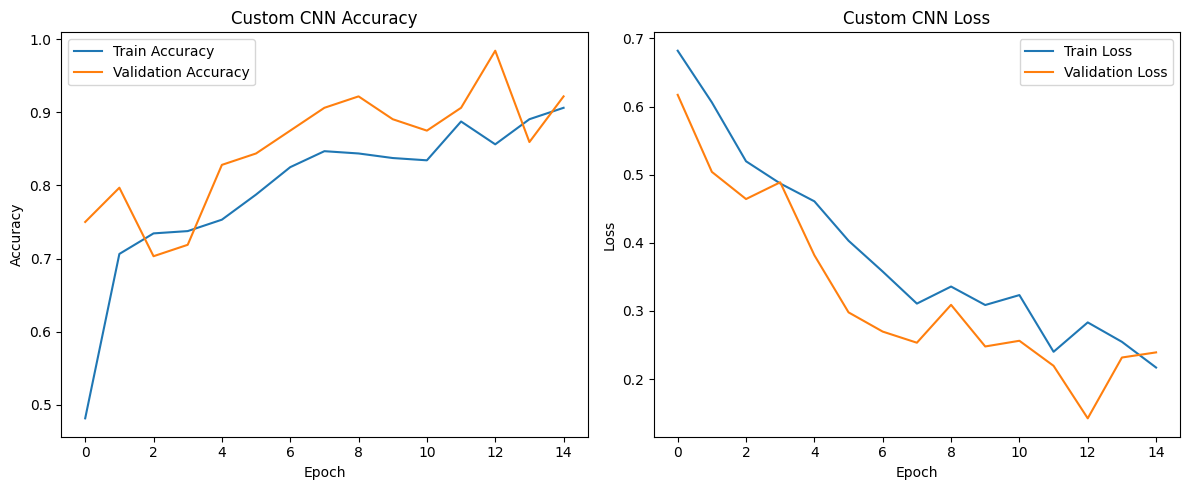

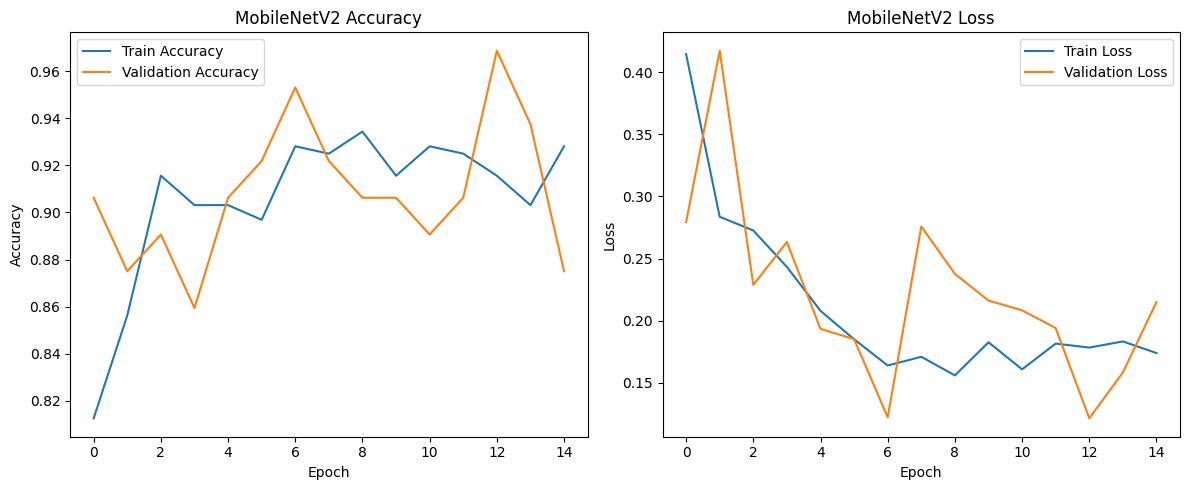

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step


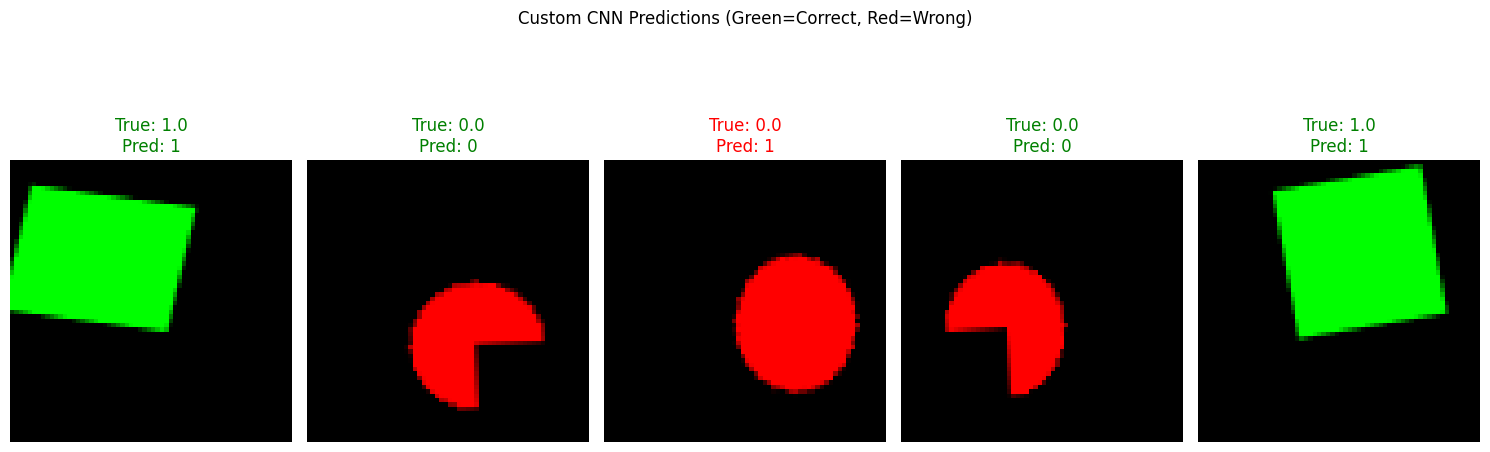

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


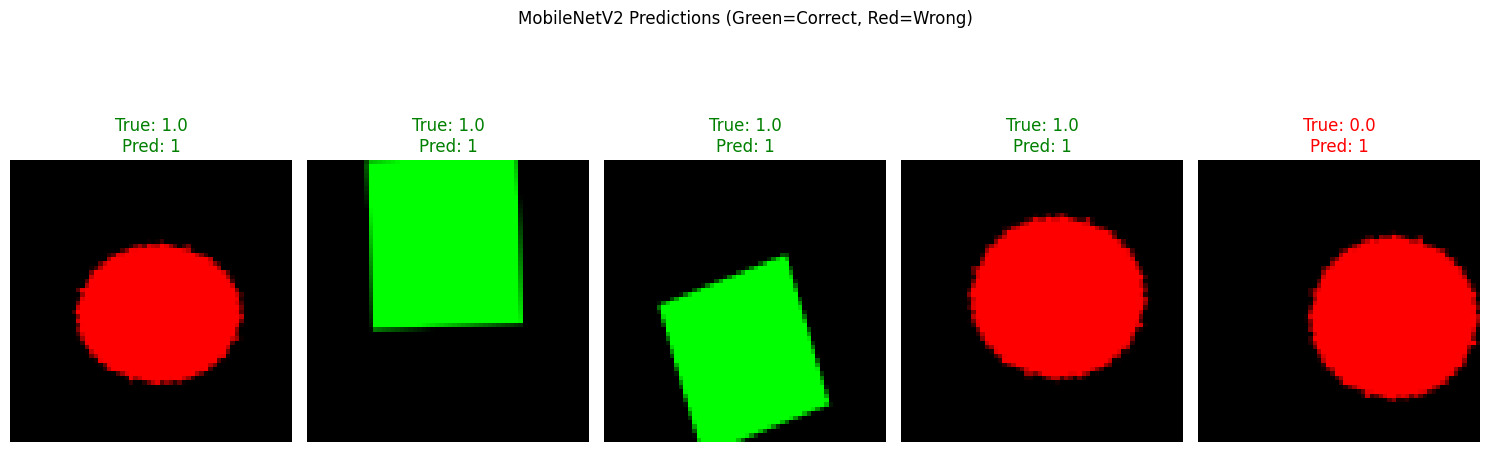

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


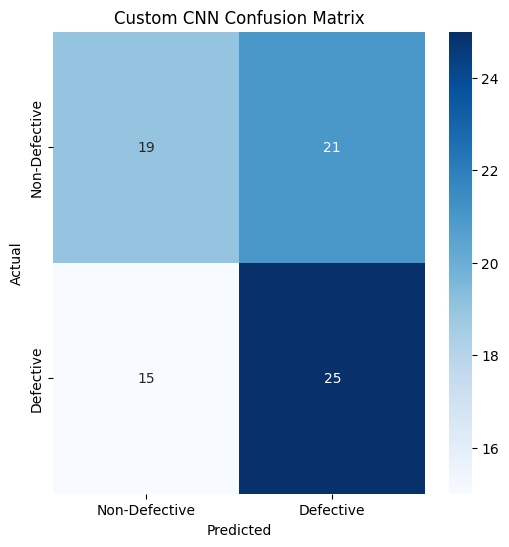

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


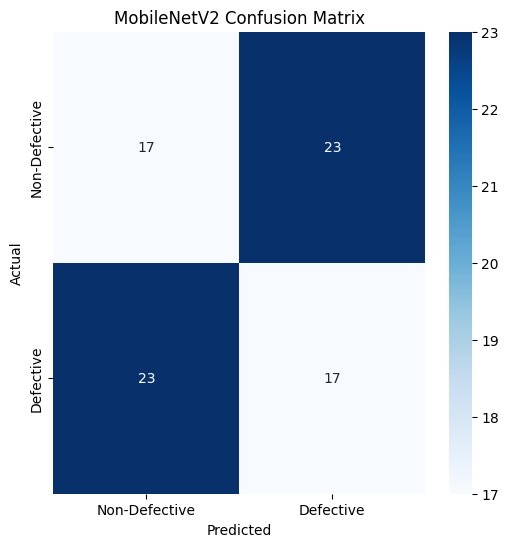

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


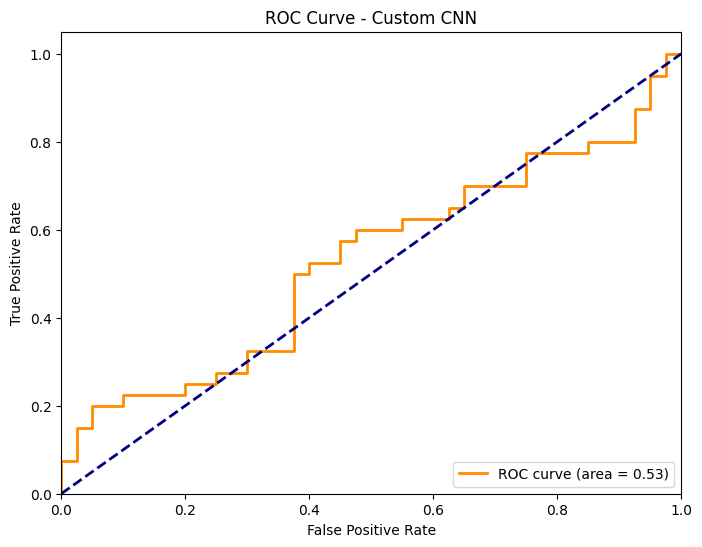

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


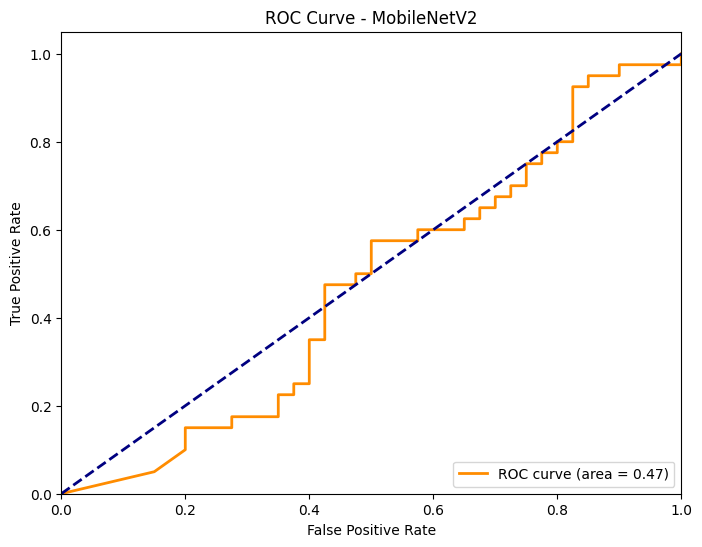


Custom CNN Feature Maps Visualization:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 64, 64, 3))
  warnings.warn(msg)


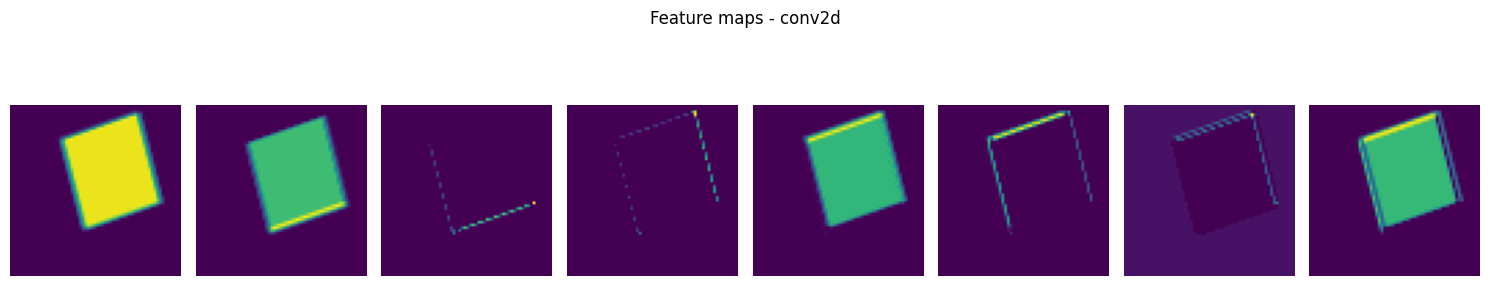

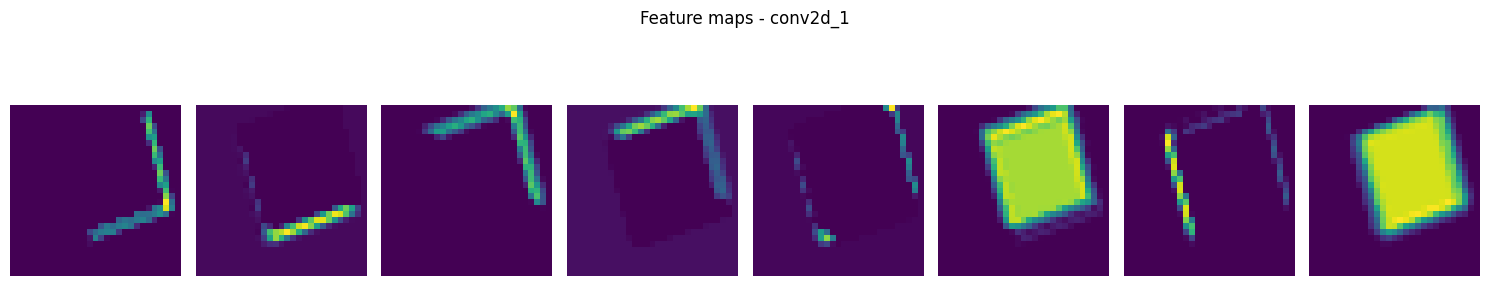

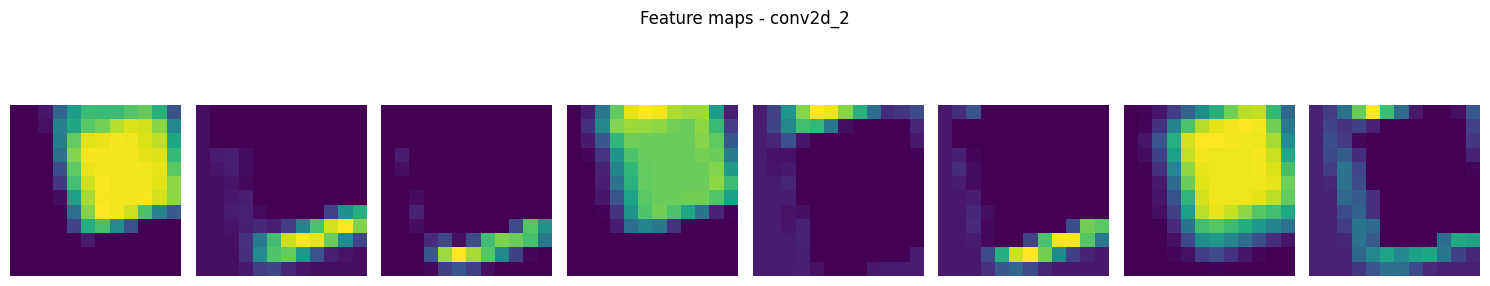

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# 1. Training History Visualization
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot training history for both models
plot_training_history(custom_history, "Custom CNN")
plot_training_history(mobilenet_history, "MobileNetV2")

# 2. Sample Predictions Visualization
def visualize_predictions(model, generator, model_name, num_samples=5):
    x_val, y_val = next(generator)
    y_pred = model.predict(x_val)
    y_pred = (y_pred > 0.5).astype(int)

    plt.figure(figsize=(15, 5))
    plt.suptitle(f"{model_name} Predictions (Green=Correct, Red=Wrong)", y=1.05)

    for i in range(num_samples):
        plt.subplot(1, num_samples, i+1)
        img = x_val[i]
        true_label = y_val[i]
        pred_label = y_pred[i][0]

        # Convert to RGB for display
        if img.shape[-1] == 1:
            img = img.squeeze()
        else:
            img = img[..., ::-1]  # BGR to RGB

        plt.imshow(img)
        title_color = 'green' if true_label == pred_label else 'red'
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=title_color)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Reset validation generator for visualization
val_generator.reset()
visualize_predictions(custom_cnn, val_generator, "Custom CNN")
val_generator.reset()
visualize_predictions(mobilenet, val_generator, "MobileNetV2")

# 3. Confusion Matrix Visualization
def plot_confusion_matrix(model, generator, model_name):
    # Get all validation predictions
    y_true = generator.classes
    y_pred = model.predict(generator)
    y_pred = (y_pred > 0.5).astype(int)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Defective', 'Defective'],
                yticklabels=['Non-Defective', 'Defective'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Reset generator before confusion matrix
val_generator.reset()
plot_confusion_matrix(custom_cnn, val_generator, "Custom CNN")
val_generator.reset()
plot_confusion_matrix(mobilenet, val_generator, "MobileNetV2")

# 4. ROC Curve Visualization
def plot_roc_curve(model, generator, model_name):
    y_true = generator.classes
    y_pred = model.predict(generator).ravel()

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Reset generator before ROC curve
val_generator.reset()
plot_roc_curve(custom_cnn, val_generator, "Custom CNN")
val_generator.reset()
plot_roc_curve(mobilenet, val_generator, "MobileNetV2")

# 5. Feature Maps Visualization (for Custom CNN)
def visualize_feature_maps(model, image, layer_names=None):
    if layer_names is None:
        layer_names = [layer.name for layer in model.layers if 'conv' in layer.name]

    # Create a model that outputs the feature maps
    outputs = [model.get_layer(name).output for name in layer_names]
    viz_model = tf.keras.models.Model(inputs=model.inputs, outputs=outputs)

    # Get feature maps
    feature_maps = viz_model.predict(np.expand_dims(image, axis=0))

    # Plot feature maps
    for i, (name, fmap) in enumerate(zip(layer_names, feature_maps)):
        if len(fmap.shape) == 4:  # convolutional layer
            plt.figure(figsize=(15, 3))
            plt.suptitle(f"Feature maps - {name}", y=1.05)

            # Display first few filters
            num_filters = min(8, fmap.shape[-1])
            for j in range(num_filters):
                plt.subplot(1, num_filters, j+1)
                plt.imshow(fmap[0, :, :, j], cmap='viridis')
                plt.axis('off')

            plt.tight_layout()
            plt.show()

# Get a sample image
val_generator.reset()
sample_image, _ = next(val_generator)
sample_image = sample_image[0]

# Visualize feature maps for Custom CNN
print("\nCustom CNN Feature Maps Visualization:")
visualize_feature_maps(custom_cnn, sample_image)